In [1]:
"""
Notebook to calculate analyse relationship between running and stimulus.
"""
import os

import numpy as np
import pickle
import scipy.stats
from matplotlib import pyplot as plt
%matplotlib inline  

import session
reload(session)

/home/colleen/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'session' from 'session.pyc'>

In [2]:
datadir='/media/colleen/LaCie/CredAssign/pilot_data/'

# Enter session to analyse
sessionid=727683236

#mouse 3 727680211, 725009252, 724421207, 724422062, 725010342, 726844248, 726837871, 727683236

sess=session.Session(datadir, sessionid)
sess.extract_info()

Loading stimulus dictionary...
Loading alignment dataframe...
NOTE: Stimulus alignment pickle already exists in /media/colleen/LaCie/CredAssign/pilot_data/ophys_session_727683236
Loading running data...
Loading ROI trace info...





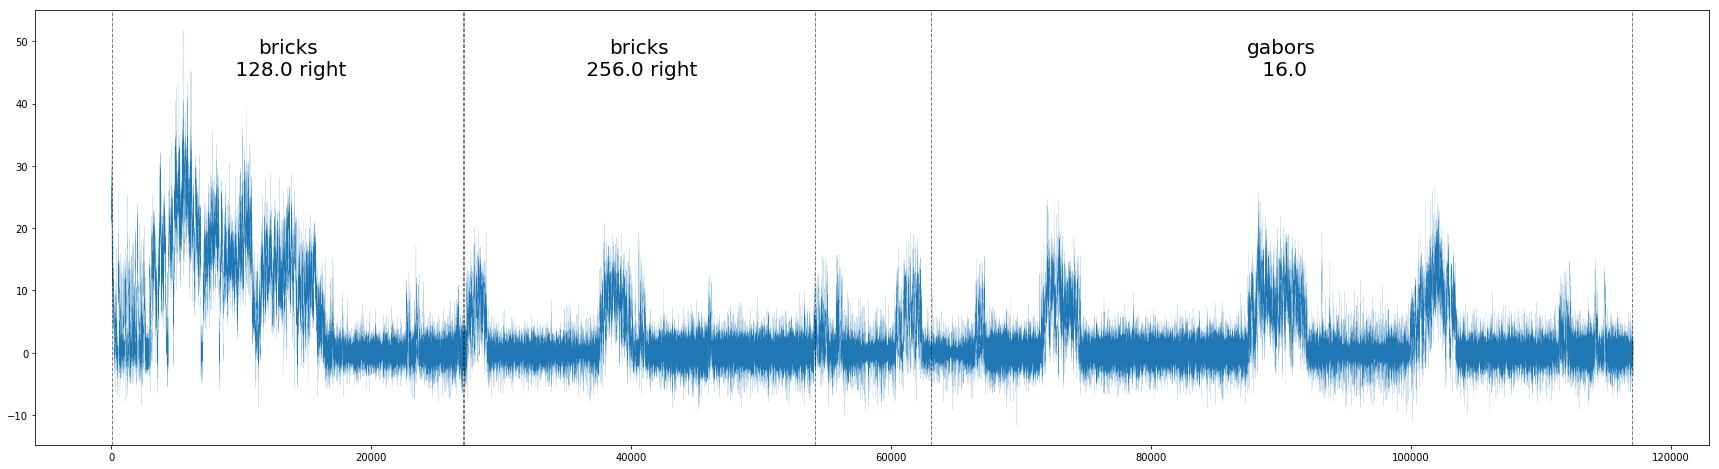

In [3]:
# plot all running
fig_run, ax_run = plt.subplots(figsize=(30, 8))
ax_run.plot(sess.run, lw=0.1)

# get the block boundaries, midpoints and params
bl_fr = [x for bl in sess.gabors.block_ran_fr for x in bl] + \
        [x for bl in sess.bricks.block_ran_fr for x in bl]
bl_par = [['gabors\n'] + [x] for bl in sess.gabors.block_params for x in bl] + \
         [['bricks\n'] + x for bl in sess.bricks.block_params for x in bl]

all_labels = []
all_lines = []
all_mids = []
for frames, params in zip(bl_fr, bl_par):
    if isinstance(params, list):
        labels =  " ".join(str(item) for item in params)
    else:
        labels = str(params)
    all_labels.extend([labels])
    all_lines.extend(frames)
    all_mids.extend([np.mean(frames)])
ymin, ymax = ax_run.get_ylim()
ypos = (ymax-ymin)*0.85+ymin

for line in all_lines:
    ax_run.axvline(x=line, ls='dashed', c='k', lw='1', alpha=0.5)
for i, label in enumerate(all_labels):
    ax_run.text(all_mids[i], ypos, label, horizontalalignment='center', fontsize=20)

Running data for gabors is not normally distributed, using median and 25-75 quartiles.
Running data for bricks is not normally distributed, using median and 25-75 quartiles.


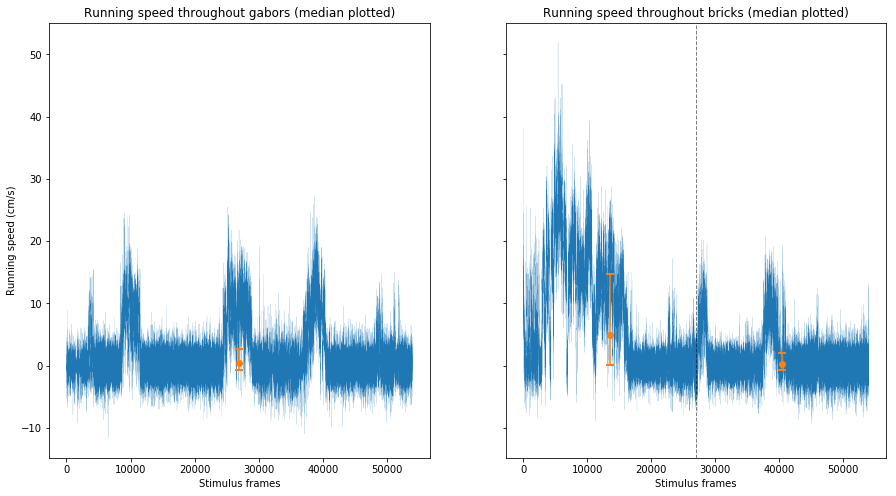

In [4]:
# plot running across all blocks

gab_run_all = sess.gabors.get_run(by='frame')
gab_run_bybl = sess.gabors.get_run(by='block')
gab_bl_mks = np.cumsum([x for sub in sess.gabors.block_len_fr 
                        for x in sub])[:-1].tolist()

# test for normality
_, gab_p = scipy.stats.normaltest(gab_run_all)
if gab_p < 0.05:
    print(('Running data for gabors is not normally '
           'distributed, using median and 25-75 quartiles.'))
    plot_stat = 'median'
else:
    plot_stat = 'mean'

if plot_stat == 'mean':
    gab_run_me_bybl  = [np.mean(x) for x 
                        in gab_run_bybl]
    gab_run_err_bybl = [np.std(x) for x 
                        in gab_run_bybl]
elif plot_stat == 'median':
    gab_run_me_bybl = [np.median(x) for x 
                           in gab_run_bybl]

    gab_run_qu_bybl = [[np.percentile(x, 25) for x 
                        in gab_run_bybl], 
                       [np.percentile(x, 75) for x 
                        in gab_run_bybl]]
    gab_run_err_bybl = [[median - qu25 for median, qu25 in zip(gab_run_me_bybl, gab_run_qu_bybl[0])],
                        [qu75 - median for median, qu75 in zip(gab_run_me_bybl, gab_run_qu_bybl[1])]]
temp = np.asarray([0] + [x for sub in sess.gabors.block_len_fr 
                         for x in sub])
gab_run_me_mks = (np.cumsum(temp)[0:-1] + np.cumsum(temp)[1:])/2

bri_run_all = sess.bricks.get_run(by='frame')
bri_run_bybl = sess.bricks.get_run(by='block')
bri_bl_mks = np.cumsum([x for sub in sess.bricks.block_len_fr 
                        for x in sub])[:-1].tolist()

# test for normality
_, bri_p = scipy.stats.normaltest(bri_run_all)
if bri_p < 0.05:
    print(('Running data for bricks is not normally '
          'distributed, using median and 25-75 quartiles.'))
    plot_stat = 'median'
else:
    plot_stat = 'mean'

if plot_stat == 'mean':
    bri_run_me_bybl = [np.mean(x) for x 
                       in bri_run_bybl]
    bri_run_err_bybl = [np.std(x) for x 
                        in bri_run_bybl]
elif plot_stat == 'median':
    bri_run_me_bybl = [np.median(x) for x 
                       in bri_run_bybl]
    bri_run_qu_bybl = [[np.percentile(x, 25) for x 
                        in bri_run_bybl], 
                       [np.percentile(x, 75) for x 
                        in bri_run_bybl]]
    bri_run_err_bybl = [[median - qu25 for median, qu25 in zip(bri_run_me_bybl, bri_run_qu_bybl[0])],
                        [qu75 - median for median, qu75 in zip(bri_run_me_bybl, bri_run_qu_bybl[1])]]
temp = np.asarray([0] + [x for sub 
                         in sess.bricks.block_len_fr for x in sub])
bri_run_me_mks = (np.cumsum(temp)[0:-1] + np.cumsum(temp)[1:])/2

# plot running across gabor blocks
fig_bl_run, ax_bl_run = plt.subplots(ncols=2, sharey=True, 
                                     figsize=(15, 8))
ax_bl_run[0].plot(gab_run_all, lw=0.1, zorder=-30)
ax_bl_run[0].errorbar(gab_run_me_mks, gab_run_me_bybl, 
                      yerr=gab_run_err_bybl, fmt='o', capsize=4, 
                      capthick=2)
ax_bl_run[0].set_title('Running speed throughout gabors ({} plotted)'.format(plot_stat))
ax_bl_run[0].set_ylabel('Running speed (cm/s)')
ax_bl_run[0].set_xlabel('Stimulus frames')
if len(gab_bl_mks) > 0:
    ax_bl_run[0].axvline(x=gab_bl_mks, ls='dashed', c='k', lw='1', alpha=0.5)

# plot running across brick blocks
ax_bl_run[1].plot(bri_run_all, lw=0.1, zorder=-30)
ax_bl_run[1].errorbar(bri_run_me_mks, bri_run_me_bybl, 
                      yerr=bri_run_err_bybl, fmt='o', capsize=4, 
                      capthick=2)
ax_bl_run[1].set_title('Running speed throughout bricks ({} plotted)'.format(plot_stat))
ax_bl_run[1].set_xlabel('Stimulus frames')
for line in bri_bl_mks:
    ax_bl_run[1].axvline(x=line, ls='dashed', c='k', lw='1', alpha=0.5)

In [5]:
def plot_chunks(axes, chunk_val, stats, rand=False, title='', hbars=None, bars=None, lw=1.5):
    if not rand:
        ax_tr = axes[0:1]
        titles = [title]
    else:
        ax_tr = axes[:]
        titles = [title, '{} (shuffled)'.format(title)]
    for v, ax in enumerate(ax_tr):
        ax.plot(chunk_val[0], chunk_val[2*v+1], lw=lw)
        if stats == 'mean':
            ax.fill_between(chunk_val[0], chunk_val[2*v+1] - chunk_val[2*v+2], 
                            chunk_val[2*v+1] + chunk_val[2*v+2], 
                            facecolor='lightblue')
        elif stats == 'median':
            ax.fill_between(chunk_val[0], chunk_val[2*v+2][0], chunk_val[2*v+2][1], 
                            facecolor='lightblue')
        thickness = [2, 1]
        torem = []
        for i, j in enumerate([hbars, bars]):
            if j is not None:
                if not isinstance(j, list):
                    j = [j]
                if i == 0:
                    torem = j
                if i == 1:
                    for r in torem:
                        if r in j:
                            j.remove(r)
                for k in j:
                    ax.axvline(x=k, ls='dashed', c='k', lw='{}'
                               .format(thickness[i]), alpha=0.5)    
        ax.set_title(titles[v])
        ax.set_ylabel('Running speed (cm/s)')
        ax.set_xlabel('Time (s)')


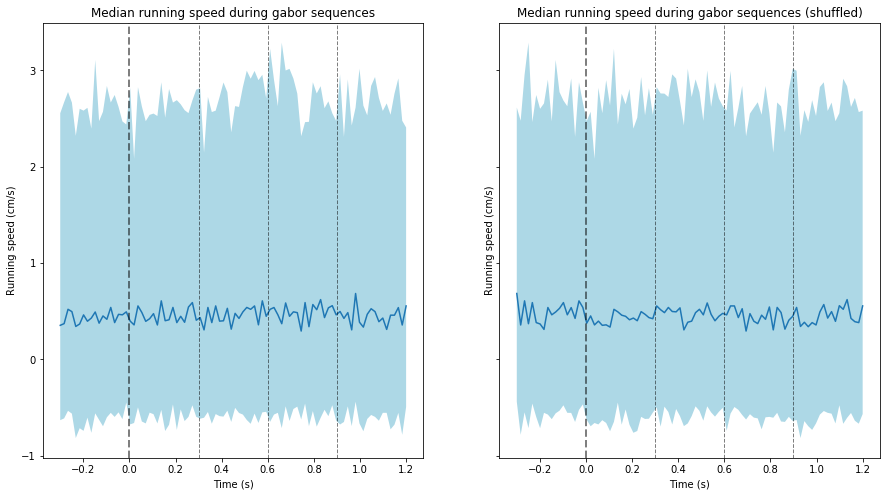

In [6]:
# plot average running through gabor sequences
# returns x_ran, run_chunks_me, run_chunks_de, run_chunks_me_rand, 
#run_chunks_de_rand
rand=True
gab_chunk = sess.gabors.get_run_chunk_stats(sess.gabors.get_A_frame_1s(by='frame'), 
                                            sess.gabors.pre, sess.gabors.post, rand=rand,
                                            stats=plot_stat)

# draw lines
h_bars = [0] # heavy at 0
# light at each segment (+1 for gray and +1 for end)
seg_bars = np.linspace(-sess.gabors.pre,sess.gabors.post, 
                       num=sess.gabors.n_seg_per_set+2)[1:-1].tolist()

# plot
if rand:
    ncols = 2
else:
    ncols = 1
fig_gabA, ax_gabA = plt.subplots(ncols=ncols, sharey=True, 
                                 figsize=(15, 8))
plot_chunks(ax_gabA, gab_chunk, plot_stat, rand, 
            title='M{} running speed during gabor sequences'.format(plot_stat[1:]), 
            hbars=h_bars, bars=seg_bars)

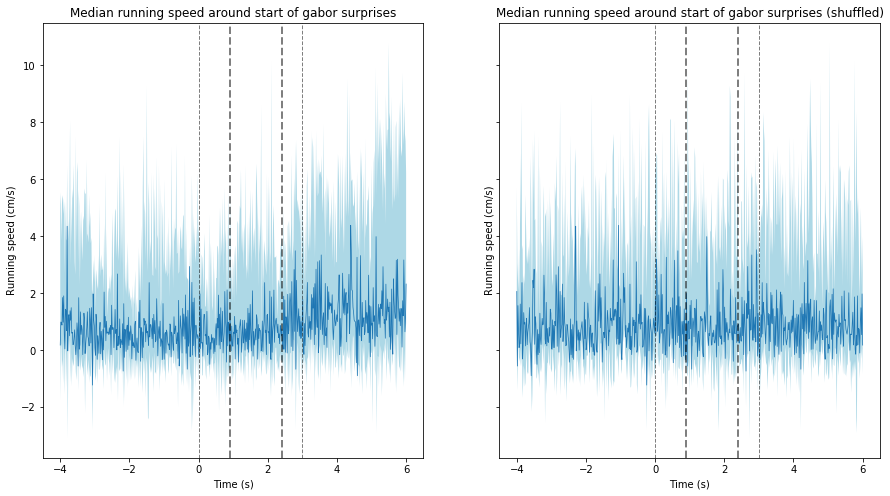

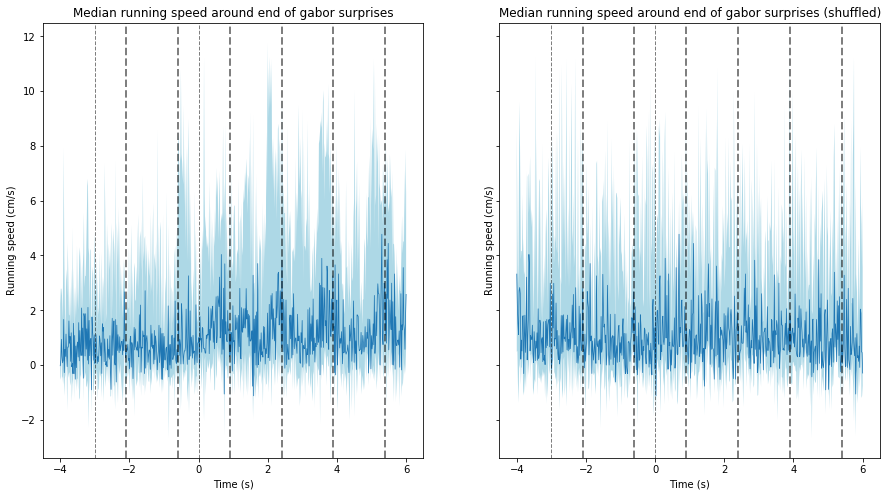

In [7]:
# plot average running through surp sequences
rand=True

# GABORS
pre=np.max([4, sess.gabors.surp_min_s])
post=np.max([4, 2*sess.gabors.surp_min_s])
# returns x_ran, run_chunks_me, run_chunks_de, run_chunks_me_rand, run_chunks_de_rand
# get chunks around surprise starts
gab_st_surp_chunk = sess.gabors.get_run_chunk_stats(sess.gabors.get_first_surp_frame_1s(by='frame')[0], 
                                                    pre, post, rand=rand, stats=plot_stat)

# get chunks around surprise ends
gab_end_surp_chunk = sess.gabors.get_run_chunk_stats(sess.gabors.get_first_surp_frame_1s(by='frame')[1], 
                                                     pre, post, rand=rand, stats=plot_stat)

set_len = sess.gabors.seg_len_s * 5
# draw lines at each surprise within surprise period
h_bars = [x * set_len + 3 * sess.gabors.seg_len_s 
          for x in range(0, int(np.ceil(sess.gabors.surp_min_s/set_len)))]
seg_bars = [0, sess.gabors.surp_min_s]

# plot
fig_gab_st_surp, ax_gab_st_surp = plt.subplots(ncols=rand*2, sharey=True, figsize=(15, 8))
plot_chunks(ax_gab_st_surp, gab_st_surp_chunk, plot_stat, rand, 
            title='M{} running speed around start of gabor surprises'.format(plot_stat[1:]), 
            hbars=h_bars, bars=seg_bars, lw=0.75)

# draw lines at each surprise within surprise and after period
h_bars = [x * set_len + 3 * sess.gabors.seg_len_s 
          for x in range(-int(np.floor(sess.gabors.surp_min_s/set_len)), 
                         int(np.ceil(post/set_len)))]
seg_bars = [-sess.gabors.surp_min_s, 0]

# plot
fig_gab_end_surp, ax_gab_end_surp = plt.subplots(ncols=rand*2, sharey=True, figsize=(15, 8))
plot_chunks(ax_gab_end_surp, gab_end_surp_chunk, plot_stat, rand, 
            title='M{} running speed around end of gabor surprises'.format(plot_stat[1:]), 
            hbars=h_bars, bars=seg_bars, lw=0.75)


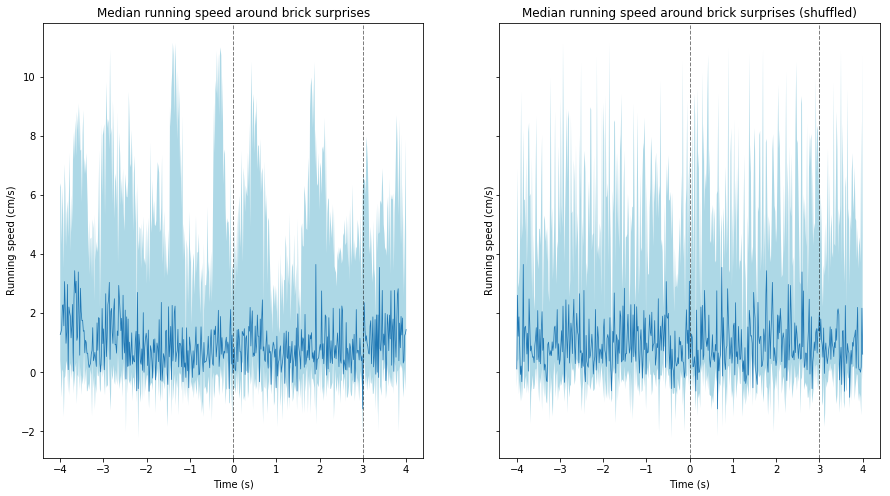

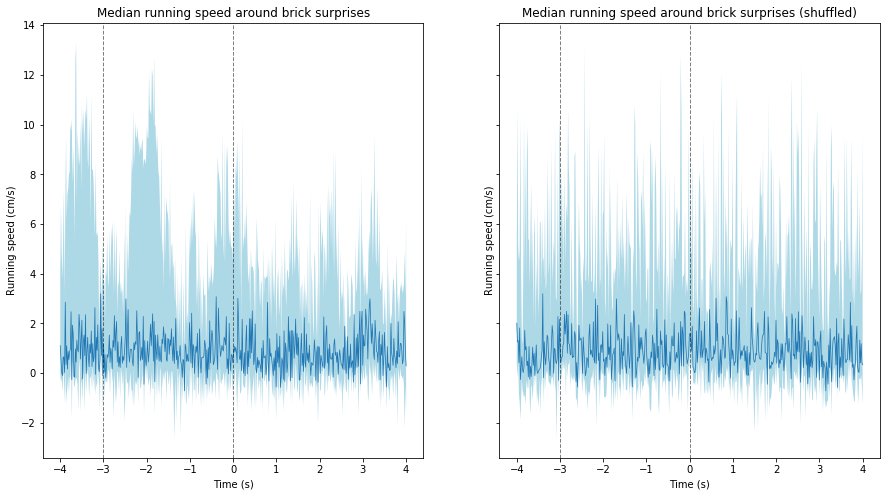

In [8]:
# BRICKS
pre=np.max([4, sess.bricks.surp_min_s])
post=np.max([4, 2*sess.bricks.surp_min_s])
# returns x_ran_av, run_chunks_av, run_chunks_std, run_chunks_av_rand, run_chunks_std_rand
# get chunks around surprise starts
bri_st_surp_chunk = sess.bricks.get_run_chunk_stats(sess.bricks.get_first_surp_frame_1s(by='frame')[0], 
                                                    pre, post, rand=rand, stats=plot_stat)
# get chunks around surprise ends
bri_end_surp_chunk = sess.bricks.get_run_chunk_stats(sess.bricks.get_first_surp_frame_1s(by='frame')[1], 
                                                     pre, post, rand=rand, stats=plot_stat)

# draw lines at each surprise within surprise period
seg_bars = [0, sess.gabors.surp_min_s]

# plot
fig_bri_st_surp, ax_bri_st_surp = plt.subplots(ncols=rand*2, sharey=True, figsize=(15, 8))
plot_chunks(ax_bri_st_surp, bri_st_surp_chunk, plot_stat, rand, 
            title='M{} running speed around brick surprises'.format(plot_stat[1:]), 
            bars=seg_bars, lw=0.75)

# draw lines at each surprise within surprise period
seg_bars = [-sess.gabors.surp_min_s, 0]

# plot
fig_bri_end_surp, ax_bri_end_surp = plt.subplots(ncols=rand*2, sharey=True, figsize=(15, 8))
plot_chunks(ax_bri_end_surp, bri_end_surp_chunk, plot_stat, rand, 
            title='M{} running speed around brick surprises'.format(plot_stat[1:]), 
            bars=seg_bars, lw=0.75)

In [9]:
def get_autocorr(stim, lag_s, run_val=None, rand=False):
    # autocorrelation function
    lag_f = int(stim.stim_fps * lag_s)

    autocorr_snips = []
    autocorr_rand_snips = []

    # flat list of gabor blocks ranges in frames
    if run_val == None:
        run_bybl = stim.get_run(by='block')
    else:
        run_bybl = run_val
    for i in run_bybl:
        norm_values = i - np.mean(i)
        # get autocorrelation snip
        autocorr = np.correlate(norm_values, norm_values, 'full')

        # autocorr will always produce an odd length, so this should 
        # always give an integer
        mid = int((autocorr.shape[0]-1)/2) 
        autocorr_snip = autocorr[mid-lag_f:mid+lag_f]

        # deep copy normalized values and randomize
        norm_rand_values = norm_values[:]
        np.random.shuffle(norm_rand_values)
        autocorr_snip_rand = np.correlate(norm_rand_values, norm_rand_values, 'full')[mid-lag_f:mid+lag_f]

        # record normalized, snipped autocorrelations
        autocorr_snips.append((autocorr_snip/np.max(autocorr_snip)).tolist())
        autocorr_rand_snips.append((autocorr_snip_rand/np.max(autocorr_snip_rand)).tolist())

    # average autocorrelations for each lag across blocks
    autocorr_mean = [float(sum(col))/len(col) for col in zip(*autocorr_snips)]
    autocorr_rand_mean = [float(sum(col))/len(col) for col in zip(*autocorr_rand_snips)]

    x_auto_ran = np.linspace(-lag_s, lag_s, 2*lag_f)
    
    if not rand:
        return x_auto_ran, autocorr_mean
    if rand:
        return x_auto_ran, autocorr_mean, autocorr_rand_mean

In [10]:
def plot_autocorr(axes, autocorr, lag_s, stimname, rand=False, hbars=None, bars=None, lw=1.5):
    title = 'Autocorrelation from -{} to {} sec for {}'.format(lag_s, lag_s, stimname)
    if not rand:
        ax_tr = axes[0:1]
        titles = [title]
    else:
        ax_tr = axes[:]
        titles = [title, '{} (shuffled)'.format(title)]
    for v, ax in enumerate(ax_tr):
        ax.plot(autocorr[0], autocorr[v+1], lw=lw)
        thickness = [2, 1]
        torem = []
        for i, j in enumerate([hbars, bars]):
            if j is not None:
                if not isinstance(j, list):
                    j = [j]
                if i == 0:
                    torem = j
                if i == 1:
                    for r in torem:
                        if r in j:
                            j.remove(r)
                for k in j:
                    ax.axvline(x=k, ls='dashed', c='k', lw='{}'
                               .format(thickness[i]), alpha=0.5)    
        ax.set_title(titles[v])
        ax.set_xticks(np.arange(-lag_s, lag_s, lag_s/5.))
        ax.set_yticks(np.arange(0, 1, 0.2))

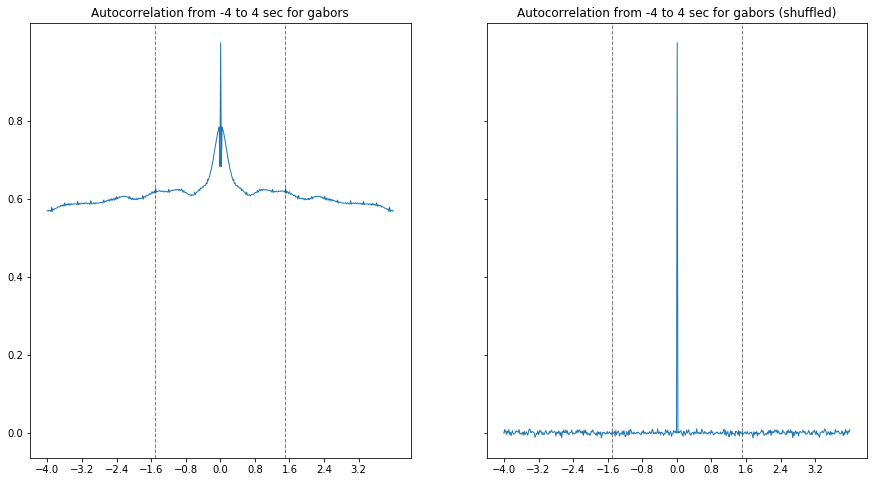

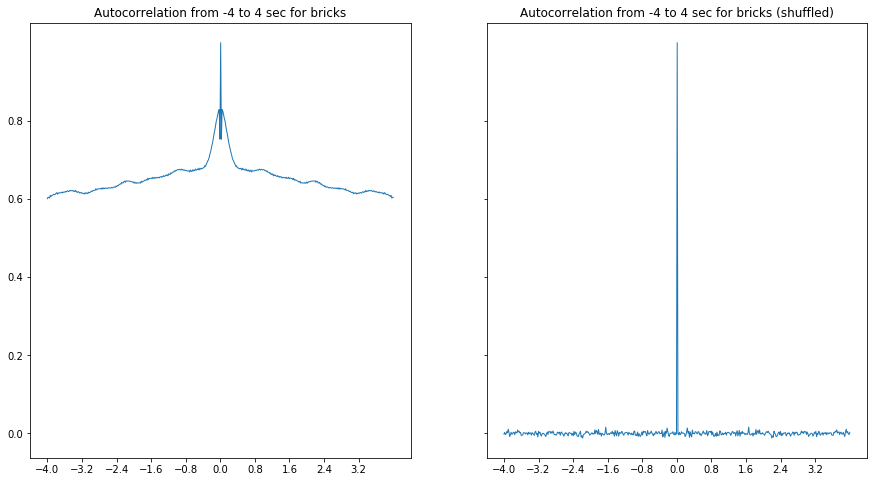

In [11]:
# plot autocorrelation around desired lag (in s) (averaged by block)
lag_s=4
rand=True
gab_lines = [-1.5, 1.5]

fig_gabautocorr, ax_gab_autocorr = plt.subplots(ncols=rand*2, sharey=True, figsize=(15, 8))
plot_autocorr(ax_gab_autocorr, get_autocorr(sess.gabors, lag_s=lag_s, rand=rand), lag_s, 
              'gabors', rand=rand, bars=gab_lines, lw=1)

fig_briautocorr, ax_bri_autocorr = plt.subplots(ncols=rand*2, sharey=True, figsize=(15, 8))
plot_autocorr(ax_bri_autocorr, get_autocorr(sess.bricks, lag_s=lag_s, rand=rand), lag_s, 
              'bricks', rand=rand, lw=1)

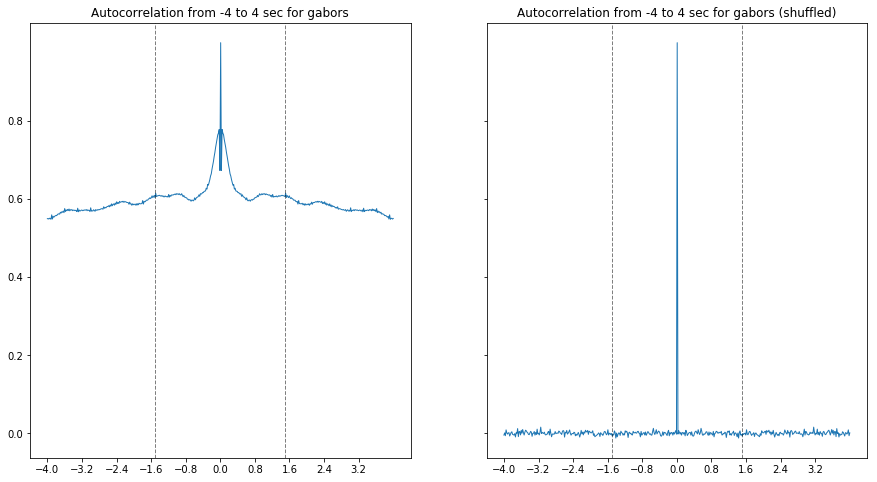

In [12]:
# plot autocorrelation around desired lag (in s) (averaged by block) without surprises
lag_s=4
rand=True
gab_lines = [-1.5, 1.5]

# get first frame for each nonsurp A
A_nosurp_first_bybl = sess.gabors.get_frames_by_criteria(gaborframe=0, surp=0, by='block')
A_nosurp_first_flat = [x for sub in A_nosurp_first_bybl for x in sub]
bl_lens = [len(x) for x in A_nosurp_first_bybl]
# get the chunks for each nonsurp seg (no longer by block)
_, _, _, nosurp_all = sess.gabors.get_run_chunk_stats(A_nosurp_first_flat, 
                                                      pre=0, post=1.5, chunks=True)
# put them back into order
# check if any values were popped
if sum(bl_lens) != len(nosurp_all):
    raise ValueError(('{} first frames were removed to get running, presumably because the frame '
                    'range would extend out of bounds. Add some code to correct for that.')
                     .format(sum(bl_lens) - len(nosurp_all)))

nosurp_all_bybl = []
prev = 0
for length in bl_lens:
    temp = [val for x in nosurp_all[prev:prev+length] for val in x]
    nosurp_all_bybl.append(temp)
    prev = prev+length

fig_gabnosurp_autocorr, ax_gabnosurp_autocorr = plt.subplots(ncols=rand*2, sharey=True, figsize=(15, 8))
plot_autocorr(ax_gabnosurp_autocorr, get_autocorr(sess.gabors, lag_s=lag_s, run_val=nosurp_all_bybl, rand=rand), lag_s, 
              'gabors', rand=rand, bars=gab_lines, lw=1)


In [13]:
# plot stats for frames
def plot_stats(plot_stat, label, run_data, ax_box, ax_bar, title=''):

    # get labels for mean or median
    me_label = ['{} {}'.format(x, plot_stat) for x in label]

    # get stats for data
    if plot_stat == 'mean':
        all_me = [np.mean(x) for x in run_data]
        all_de = [scipy.stats.sem(x) for x in run_data]
        de_label = ['{} sem'.format(x) for x in label]
    elif plot_stat == 'median':
        all_me = [np.median(x) for x in run_data]
        # get the median absolute deviation for each dataset
        all_de = [np.median(x) for x in [[np.abs(val - all_me[i]) for val in arr] 
                                          for i, arr in enumerate(run_data)]]
        de_label = ['{} mad'.format(x) for x in label]

    box_labels = ['{} (n={})'.format(lab, len(data)) for lab, data in zip(label, run_data)]

    # boxplots of data
    ax_box.boxplot(run_data, vert=False)
    ax_box.set_title(title)
    ax_box.set_xlabel('Running speed (cm/s)')
    ax_box.set_yticklabels(box_labels)

    # barplots of statistics
    ax_bar[0].set_title('Stats for r{}'.format(title[1:]))
    ax_bar[0].barh(me_label, all_me)

    ax_bar[1].barh(de_label, all_de)
    ax_bar[1].set_xlabel('Running speed (cm/s)')

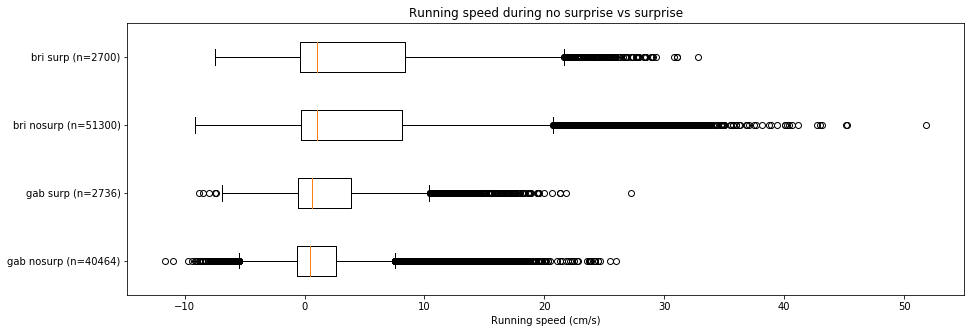

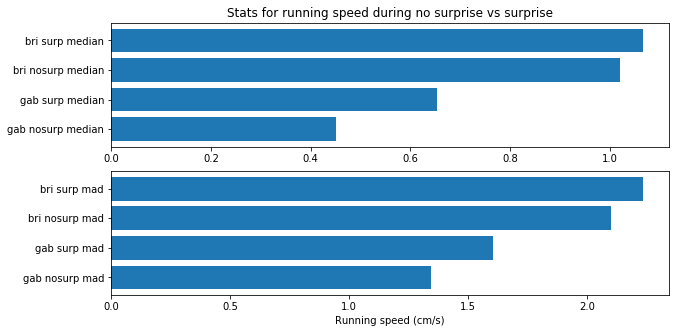

In [52]:
# stats for surprise vs no surprise (bricks, gabors) (NO GRAYSCR)
# NOTE: Gabor surprise data not as interesting as it's so short and only frame 3 is surprising
gab_surp_run, gab_nosurp_run = [sess.run[x] for x in sess.gabors.get_all_surp_frames(by='frame')] # excludes grayscr
bri_surp_run, bri_nosurp_run = [sess.run[x] for x in sess.bricks.get_all_surp_frames(by='frame')] # excludes grayscr

# CHECK ORDER!!!
label_surp = ['gab nosurp', 'gab surp', 'bri nosurp', 'bri surp']
run_data_surp = [gab_nosurp_run, gab_surp_run, bri_nosurp_run, bri_surp_run]

# boxplots of data
fig_surp, ax_surp = plt.subplots(figsize=(15, 5))
title_surp = 'Running speed during no surprise vs surprise'

# barplots of statistics
fig_surp_st, ax_surp_st = plt.subplots(nrows=2, figsize=(10, 5))

plot_stats(plot_stat, label_surp, run_data_surp, ax_surp, ax_surp_st, title=title_surp)

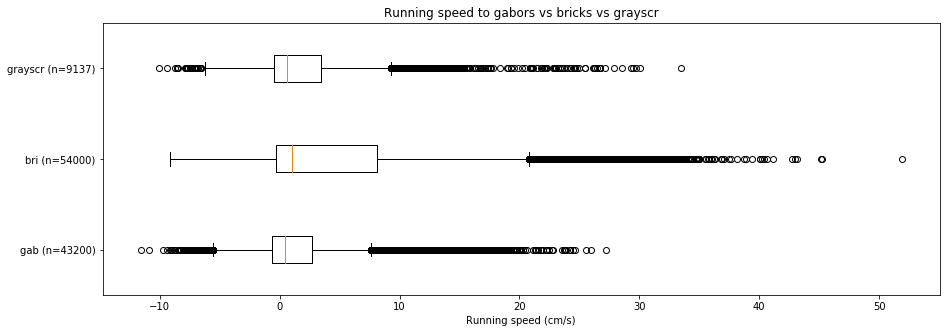

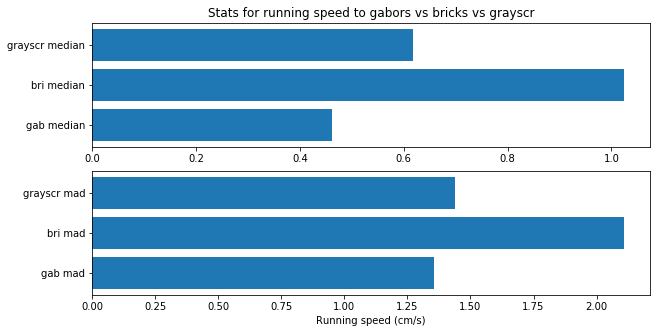

In [53]:
# stats for surprise vs no surprise (bricks, gabors) (NO GRAYSCR)
gab_run = sess.run[sess.gabors.get_frames_by_criteria(first_fr=False, by='frame')]
bri_run = sess.run[sess.bricks.get_frames_by_criteria(first_fr=False, by='frame')]
grayscr_run = sess.run[sess.grayscr.get_all_nongab_frames()]
#grayscr_run_gab = sess.run[sess.grayscr.get_all_gab_frames(by='frame')]

# CHECK ORDER!!!
label_run = ['gab', 'bri', 'grayscr']
run_data = [gab_run, bri_run, grayscr_run]

# boxplots of data
fig_run, ax_run = plt.subplots(figsize=(15, 5))
title_run = 'Running speed to gabors vs bricks vs grayscr'

# barplots of statistics
fig_run_st, ax_run_st = plt.subplots(nrows=2, figsize=(10, 5))

plot_stats(plot_stat, label_run, run_data, ax_run, ax_run_st, title=title_run)

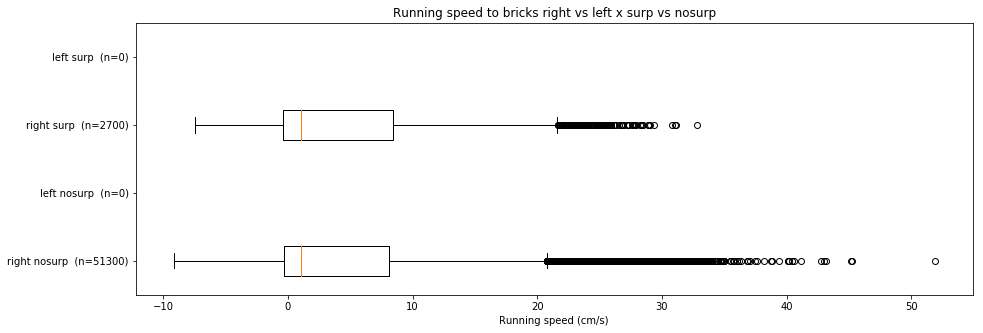

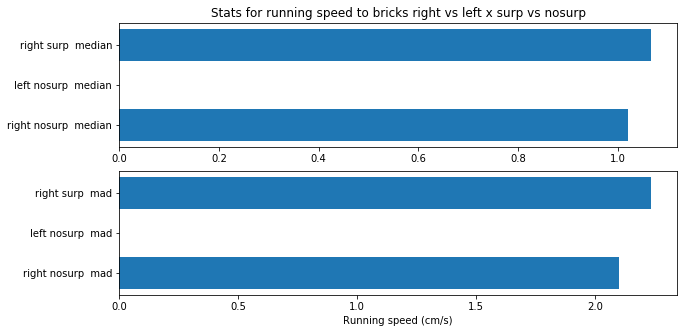

In [54]:
# stats for surprise vs no surprise (bricks, gabors) (NO GRAYSCR)
try:
    bri_run_right_nosurp = sess.run[sess.bricks.get_frames_by_criteria(stimPar2='right', surp=0, first_fr=False, by='frame')]
except:
    bri_run_right_nosurp = []
try:
    bri_run_left_nosurp  = sess.run[sess.bricks.get_frames_by_criteria(stimPar2='left', surp=0, first_fr=False, by='frame')]
except:
    bri_run_left_nosurp = []
try:
    bri_run_right_surp = sess.run[sess.bricks.get_frames_by_criteria(stimPar2='right', surp=1, first_fr=False, by='frame')]
except:
    bri_run_right_surp = []
try:
    bri_run_left_surp  = sess.run[sess.bricks.get_frames_by_criteria(stimPar2='left', surp=1, first_fr=False, by='frame')]
except:
    bri_run_left_surp = []

# CHECK ORDER!!!
label_dir = ['right nosurp ', 'left nosurp ', 'right surp ', 'left surp ']
run_data_dir = [bri_run_right_nosurp, bri_run_left_nosurp, bri_run_right_surp, bri_run_left_surp]

# boxplots of data
fig_dir, ax_dir = plt.subplots(figsize=(15, 5))
title_dir = 'Running speed to bricks right vs left x surp vs nosurp'

# barplots of statistics
fig_dir_st, ax_dir_st = plt.subplots(nrows=2, figsize=(10, 5))

plot_stats(plot_stat, label_dir, run_data_dir, ax_dir, ax_dir_st, title=title_dir)